# Oxygen field validation

In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.12.89:44329")
client

Client Scheduler: tcp://10.32.12.89:44329 Dashboard: /user/0000-0001-8571-865x/proxy/8787/status,Cluster Workers: 1 Cores: 2 Memory: 11.50 GB


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import xarray as xr
import intake
import util
import warnings
import matplotlib.pyplot as plt

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
#     col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")
    col = intake.open_esm_datastore("../../intake-esm-datastore/catalogs/pangeo-cmip6.json")

# find all oxygen fields for historical run
cat = col.search(variable_id=['o2'], experiment_id=['historical'])
cat.df
# ok cool there are a bunch!
data_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 12 group(s)


In [4]:
def promote_empty_dims(ds):
    ds = ds.copy()
    for di in ds.dims:
        if di not in ds.coords:
            ds.coords[di] = ds[di]
    return ds

In [22]:
# clean the data

# First promote all empty dims to coordinates
data_dict_clean = {k: promote_empty_dims(ds) for k, ds in data_dict.items()}

# then rename all datasets in a consistent way
from cmip6_preprocessing.preprocessing import rename_cmip6
data_dict_clean = {k: rename_cmip6(ds) for k, ds in data_dict_clean.items()}

# Now weed out duplicates
del data_dict_clean['CMIP.CCCma.CanESM5.historical.Omon.gn']
# del data_dict_clean['CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn'] 
del data_dict_clean['CMIP.IPSL.IPSL-CM6A-LR.historical.Oyr.gn'] #!!! this has the weird olevel
del data_dict_clean['CMIP.MIROC.MIROC-ES2L.historical.Omon.gn']
del data_dict_clean['CMIP.NCC.NorCPM1.historical.Omon.gr']

def patch_processing_shit(ds):
    ds = ds.copy()
     # patch for GFDL regridded models (needs to go to preprocessing)
    # make a separate dict...
    if ds.attrs['grid_label'] == 'gr' and ds.attrs['institution_id'] in ['NOAA-GFDL']:
        ds = ds.copy()
        ds = ds.rename({'lon':'x', 'lat':'y'})
        ds.coords['lon'] = ds['x']
        ds.coords['lat'] = ds['y']
    return ds
    

# average over last decade
data_dict_clean = {k:patch_processing_shit(ds).o2.sel(time=slice('2004', '2014')).mean('time') for k, ds in data_dict_clean.items()}
# !!!! if I dont preselect o2 here I get this weird error about cftime comparison...
# For now work around by patching attrs into the dataarray
def patch_attrs(da, ds):
    da = da.copy()
    ds = ds.copy()
    for atts in ['source_id', 'grid_label']:
        da.attrs[atts] = ds.attrs[atts]
    return da
data_dict_clean = {k:patch_attrs(data_dict_clean[k], data_dict[k]).persist() for k in data_dict_clean.keys()}

## Plot map at 100m

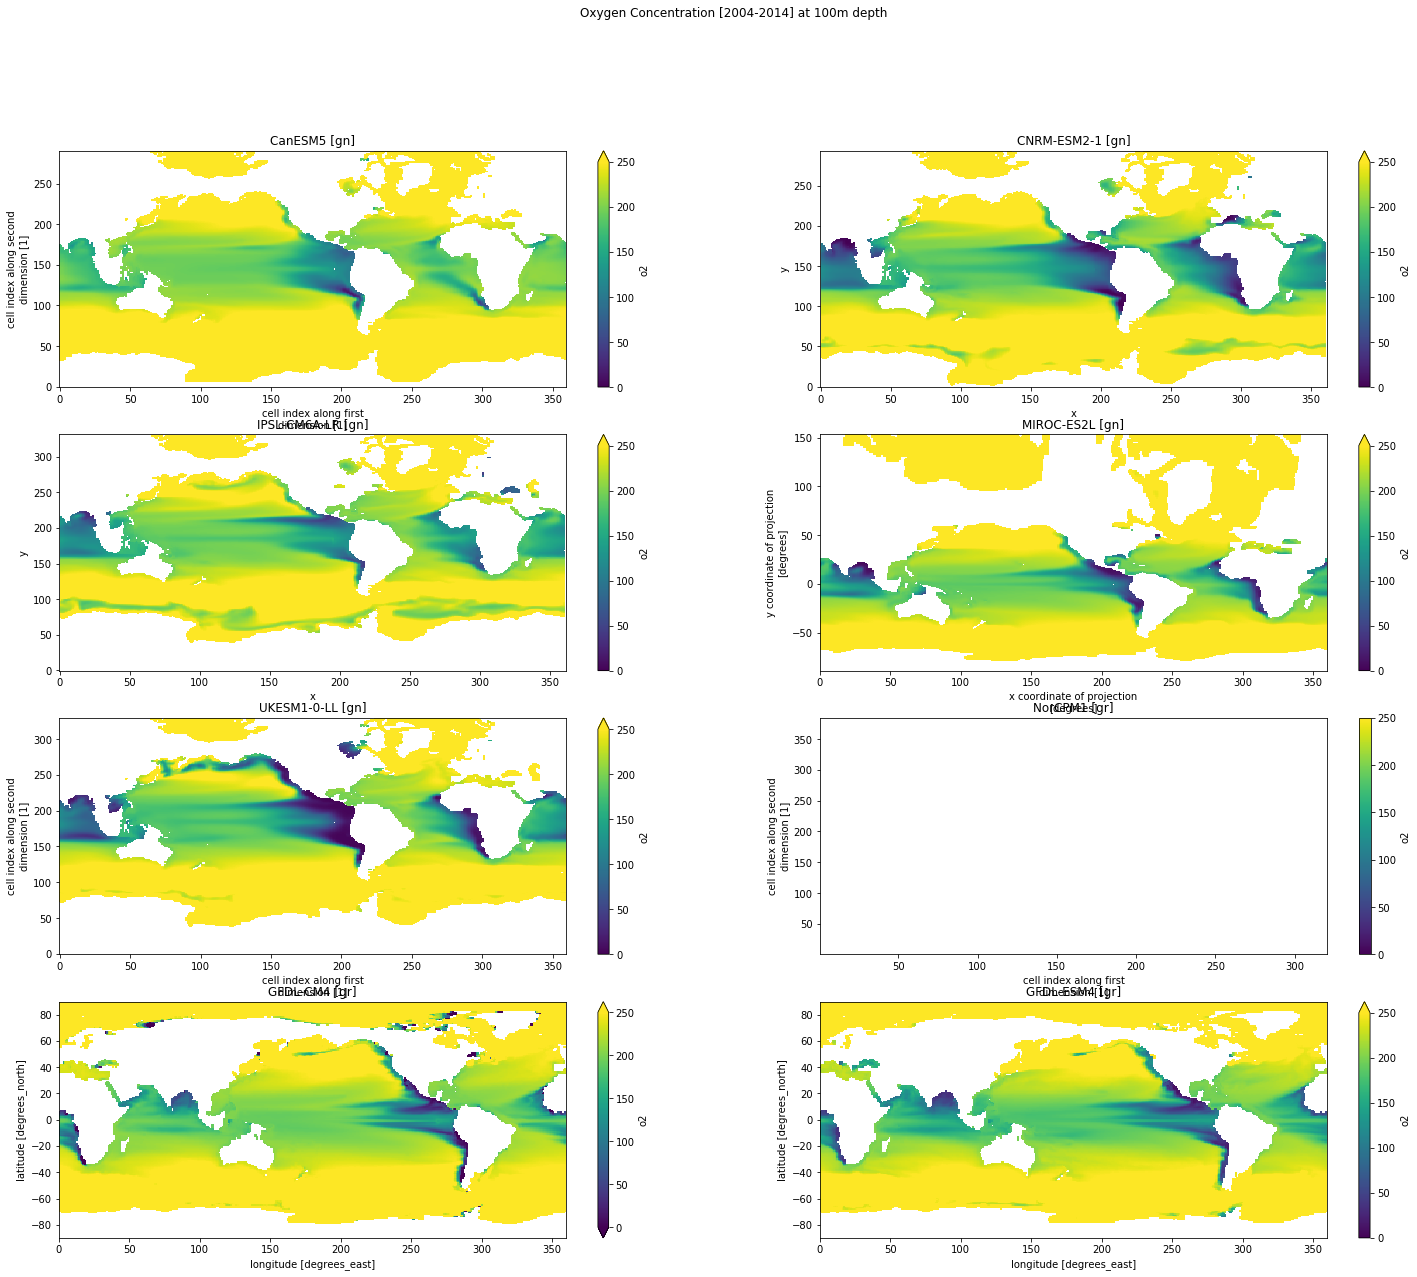

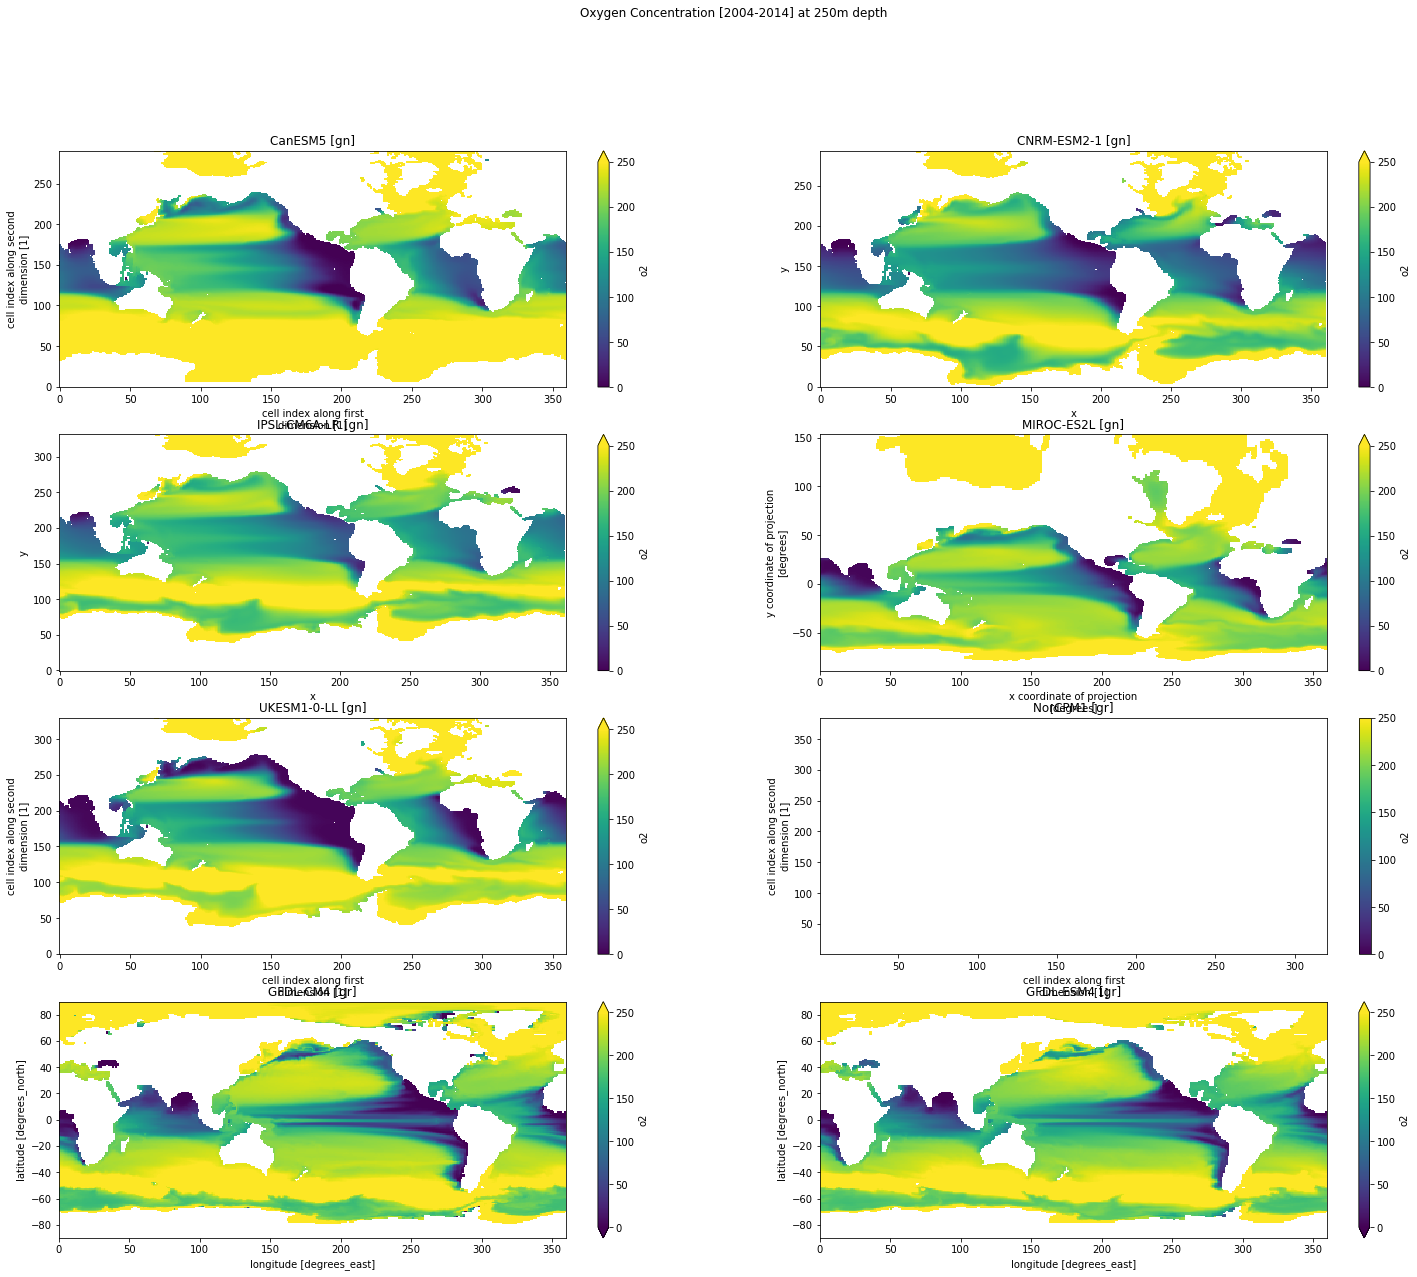

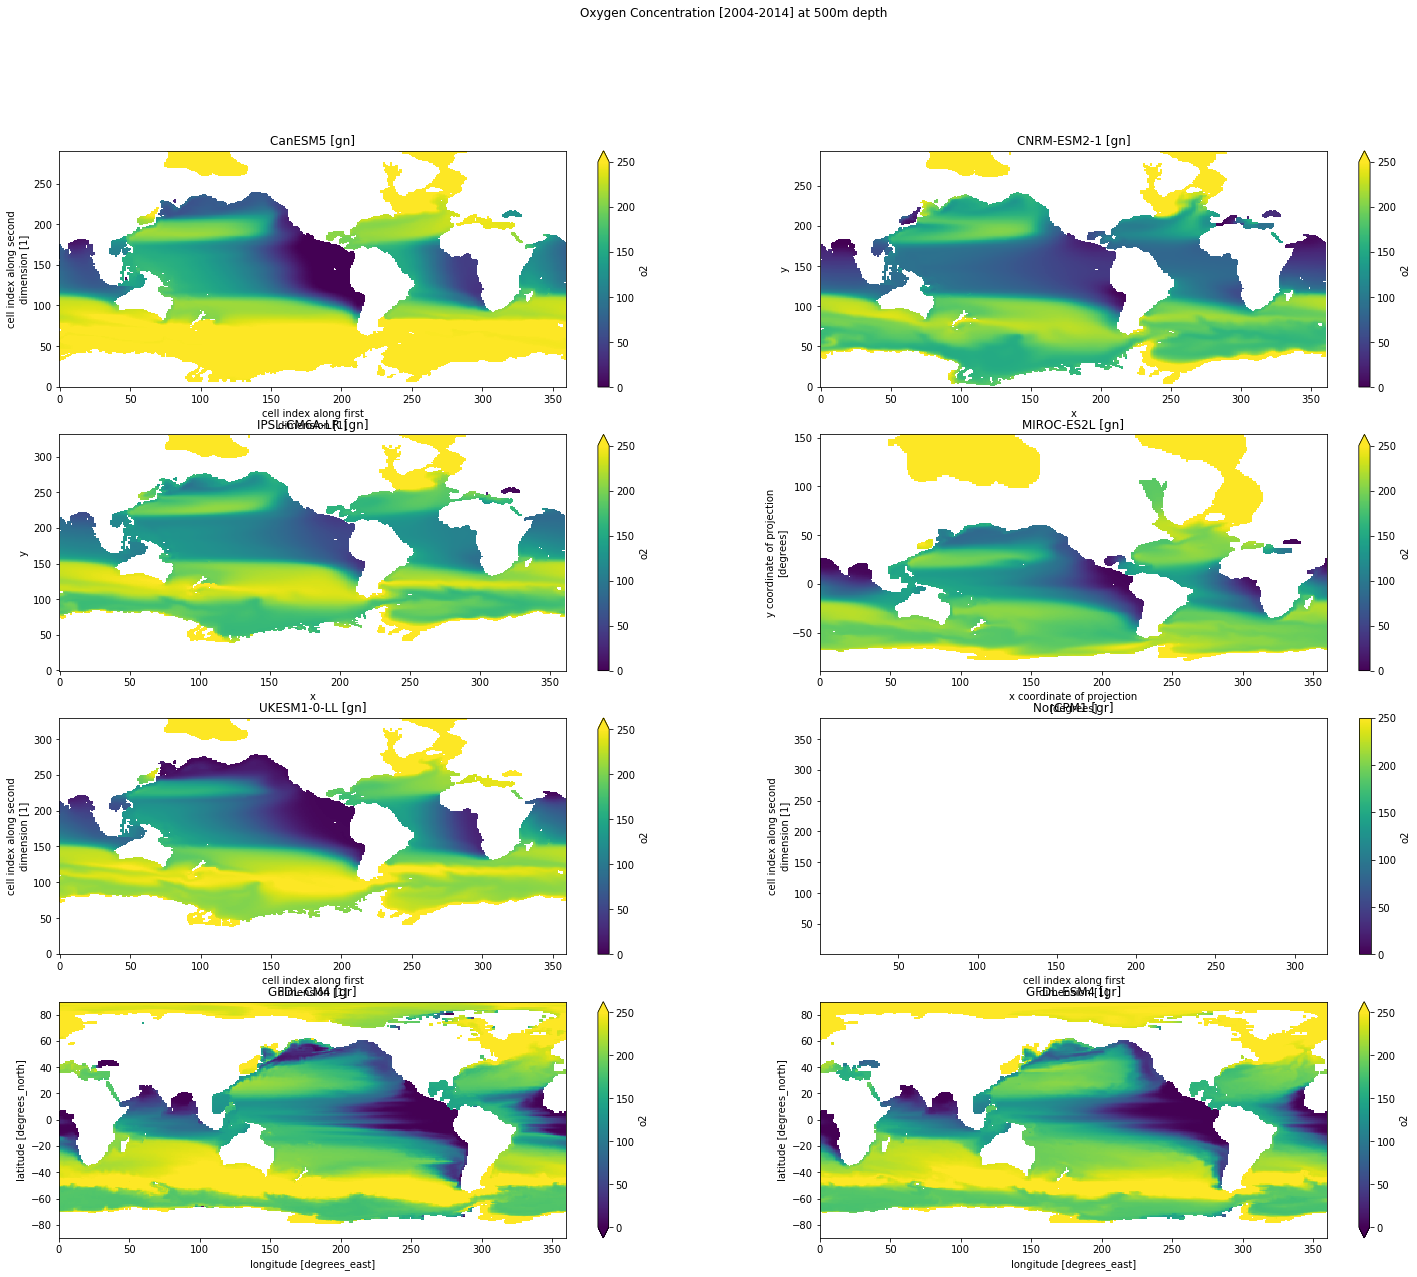

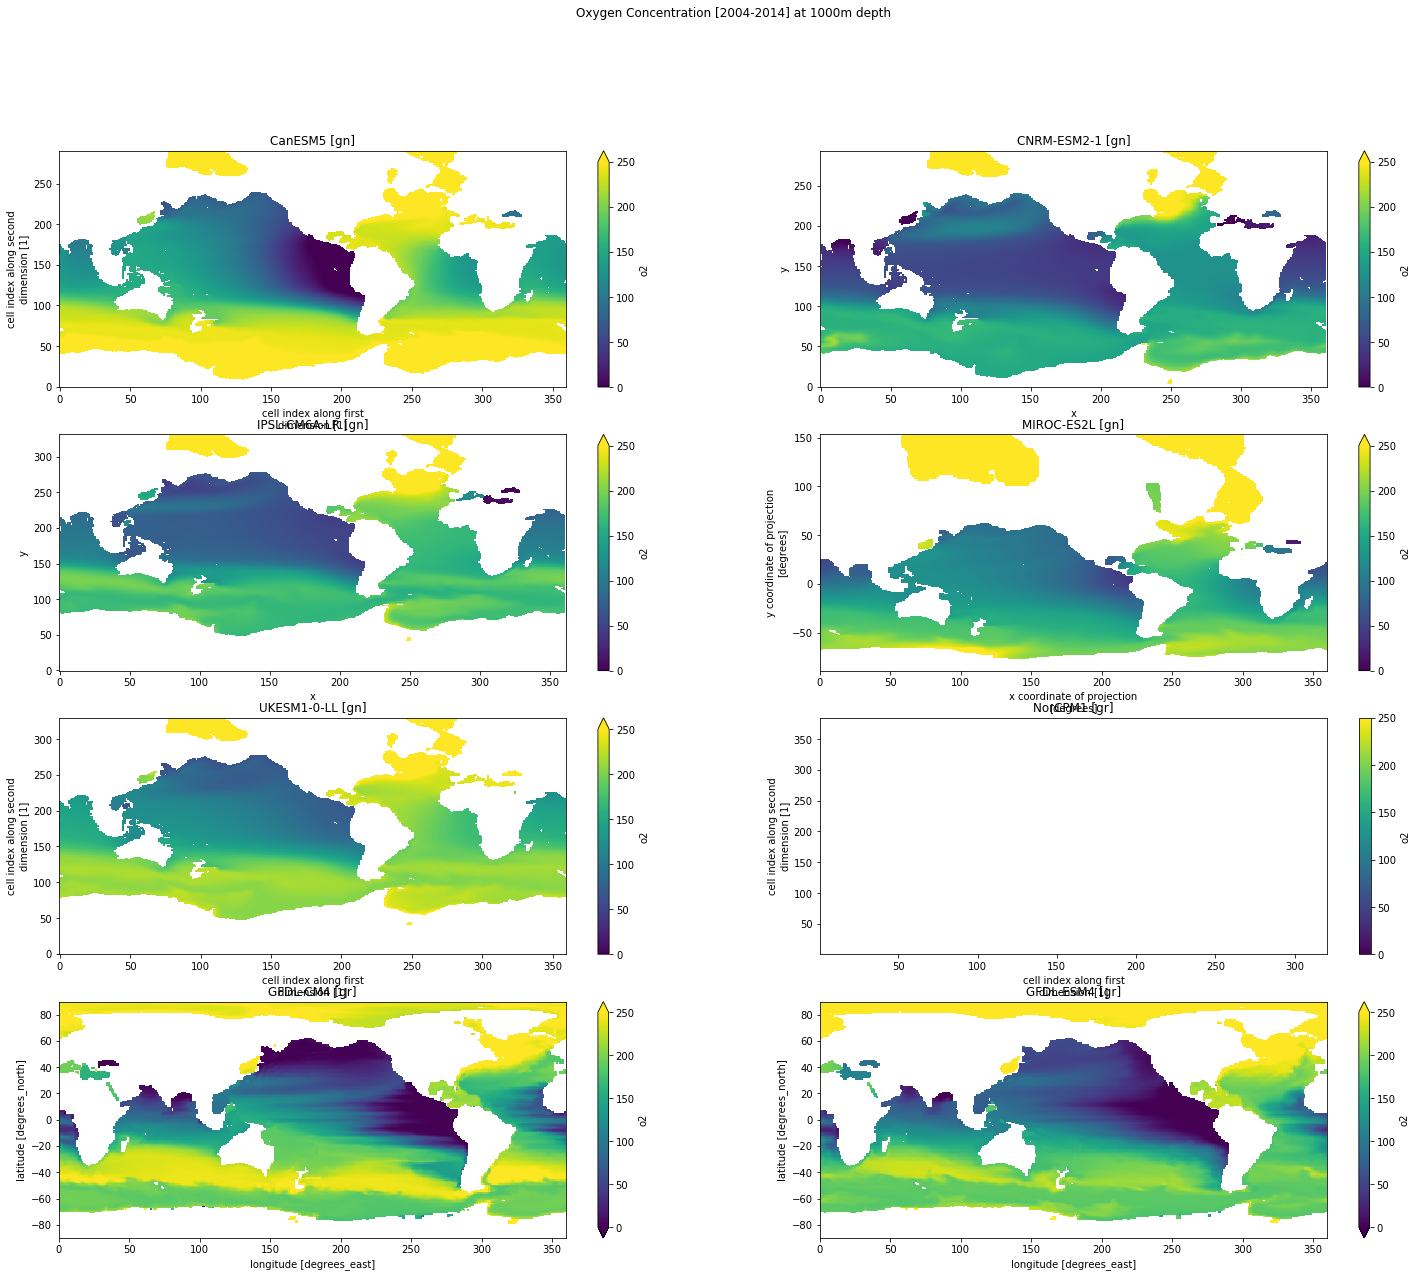

In [23]:

for z in [100, 250, 500, 1000]:
    fig, axarr = plt.subplots(ncols=2, nrows=4, figsize=[25,20])
    for ax, (mod, ds) in zip(axarr.flat, data_dict_clean.items()):    
        # interpret level
        pds = ds.interp(lev=z)
        
        # convert to mymol/kg
        rho_ref = 1035
        pds = pds * 1e6 / rho_ref
        pds.attrs['units'] = ['mumol/kg']


        if 'member_id' in ds.dims:
            pds = pds.mean('member_id')

        pds.plot(ax=ax, vmax=250, vmin=0)
        ax.set_title('%s [%s]' %(ds.attrs['source_id'], ds.attrs['grid_label']))
        
    fig.suptitle('Oxygen Concentration [2004-2014] at %im depth' %z)

## Encountered problems
- The gr naming is yet different from the gr....need sep dict for those...
- Some resampling did not work, gotta see what is going on there . But the selecting works for now
- THe norwegian model has a historical run that starts after 2014 ...oyyy
- The french model still has that olevel crap...
- Fix the projection for the maps

## Next steps:
- get the vertical spacing:
    - Get the thickness
    - depth of the OMZ boundary
    - OMZ volume?
- Latitude slice [difficult since the labels are often not nominal lons and lats]